In [203]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.layers import RepeatVector
from keras.layers import Dropout
from numpy import hstack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [204]:
def form(yhat,y,mode,ix=3):
    tp=[]
    tn=[]
    fn=[]
    fp=[]
    yuzdelik=[[],[],[],[]]
    if mode==1:
        for index,i in enumerate(yhat):
            result=i[ix]-y[index-1,ix]
            if index==0:
                continue
            if y[index-1,ix]>y[index,ix]:#dusmus
                if result>0: 
                    fn.append(abs(i[ix]-y[index,ix]))#negatif
                    yuzdelik[2].append((y[index,ix]/y[index-1,ix])-1)
                else:
                    tn.append(abs(i[ix]-y[index,ix]))
                    yuzdelik[3].append((y[index,ix]/y[index-1,ix])-1)
            else:  #artmis
                if result>0: 
                    tp.append(abs(i[ix]-y[index,ix]))#negatif
                    yuzdelik[0].append((y[index,ix]/y[index-1,ix])-1)
                else:
                    fp.append(abs(i[ix]-y[index,ix]))
                    yuzdelik[1].append((y[index,ix]/y[index-1,ix])-1)
    elif mode==0:
        for index,i in enumerate(yhat):
            result=i-y[index-1]
            if index==0:
                continue
            if y[index-1]>y[index]:#dusmus
                if result>0: 
                    fn.append(abs(i-y[index]))#negatif
                    yuzdelik[2].append((y[index]/y[index-1])-1)
                else:
                    tn.append(abs(i-y[index]))
                    yuzdelik[3].append((y[index]/y[index-1])-1)
            else:  #artmis
                if result>0: 
                    tp.append(abs(i-y[index]))#negatif
                    yuzdelik[0].append((y[index]/y[index-1])-1)
                else:
                    fp.append(abs(i-y[index]))
                    yuzdelik[1].append((y[index]/y[index-1])-1)
        
    print()
    print('Mean')
    print([np.mean(tp),"%{}".format(np.mean(yuzdelik[0])*100),"||||",np.mean(fp),"%{}".format(np.mean(yuzdelik[1])*100)])
    print([np.mean(fn),"-%{}".format(np.mean(np.abs(yuzdelik[2])*100)),"||||",np.mean(tn),"-%{}".format(np.mean(np.abs(yuzdelik[3]))*100)])
    print()
    print('Count')
    print([len(tp),len(fp)])
    print([len(fn),len(tn)])
    print("acc %{}".format((len(tp)+len(tn))/(len(tp)+len(fp)+len(fn)+len(tn))))
    print()
    print('Max')
    print([np.max(tp),"%{}".format(np.max(yuzdelik[0])*100),"||||",np.max(fp),"%{}".format(np.max(yuzdelik[1])*100)])
    print([np.max(fn),"-%{}".format(np.max(np.abs(yuzdelik[2])*100)),"||||",np.max(tn),"-%{}".format(np.max(np.abs(yuzdelik[3]))*100)])
    print()
    print('Min')
    print([np.min(tp),"%{}".format(np.min(np.abs(yuzdelik[0]))*100),"||||",np.min(fp),"%{}".format(np.min(np.abs(yuzdelik[1]))*100)])
    print([np.min(fn),"-%{}".format(np.min(np.abs(yuzdelik[2]))*100),"||||",np.min(tn),"-%{}".format(np.min(np.abs(yuzdelik[3]))*100)])
    print()


In [205]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [206]:
dataset= pd.read_csv('augmento_btc.csv')

In [207]:
dataset.head()

,date,listing_close,twitter_hacks,twitter_pessimistic_doubtful,twitter_banks,twitter_selling,twitter_market_manipulation,twitter_de_centralisation,twitter_angry,twitter_etf,...,reddit_buying,reddit_warning,reddit_annoyed_frustrated,reddit_price,reddit_use_case_applications,reddit_rumor,reddit_scam_fraud,reddit_airdrop,reddit_optimistic,reddit_negative
0,2016-11-01 01:00:00,706.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,6.0,2.0,0.0,0.0,0.0,1.0,12.0
1,2016-11-01 02:00:00,709.99,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,2.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,1.0,8.0
2,2016-11-01 03:00:00,708.54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,2.0,7.0
3,2016-11-01 04:00:00,702.85,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,5.0
4,2016-11-01 05:00:00,708.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,5.0,3.0,0.0,0.0,0.0,1.0,7.0


In [208]:
col=dataset.columns

In [209]:
for i,c in enumerate(col):
    print(i,c)

0 date
1 listing_close
2 twitter_hacks
3 twitter_pessimistic_doubtful
4 twitter_banks
5 twitter_selling
6 twitter_market_manipulation
7 twitter_de_centralisation
8 twitter_angry
9 twitter_etf
10 twitter_leverage
11 twitter_bottom
12 twitter_institutional_money
13 twitter_fomo
14 twitter_prediction
15 twitter_adoption
16 twitter_fearful_concerned
17 twitter_portfolio
18 twitter_fud_theme
19 twitter_whitepaper
20 twitter_announcements
21 twitter_technical_analysis
22 twitter_flippening
23 twitter_community
24 twitter_investing_trading
25 twitter_euphoric_excited
26 twitter_hodling
27 twitter_ico
28 twitter_bearish
29 twitter_going_short
30 twitter_uncertain
31 twitter_volume
32 twitter_risk
33 twitter_governance
34 twitter_ban
35 twitter_cheap
36 twitter_short_term_trading
37 twitter_fork
38 twitter_progress
39 twitter_shilling
40 twitter_bullish
41 twitter_happy
42 twitter_bubble
43 twitter_bots
44 twitter_hopeful
45 twitter_bug
46 twitter_open_source
47 twitter_token_economics
48 twitt

In [210]:
imp_col_index_good=[25,32,40,41,44,56,65,77,93]
imp_col_index_bad=[8,16,28,32,50,55,56,75,86,87,94]


icolindex_good=[0]
icolindex_bad=[0]

icolindex_good.extend([i for i in imp_col_index_good])
icolindex_good.extend([i+93 for i in imp_col_index_good])#for cointalk
icolindex_good.extend([i+93*2 for i in imp_col_index_good]) #for reddit

icolindex_bad.extend([i for i in imp_col_index_bad])
icolindex_bad.extend([i+93 for i in imp_col_index_bad])
icolindex_bad.extend([i+93*2 for i in imp_col_index_bad])


dataset_good=dataset.loc[:,col[icolindex_good]]
dataset_bad=dataset.loc[:,col[icolindex_bad]]

In [211]:
dataset_good

,date,twitter_euphoric_excited,twitter_risk,twitter_bullish,twitter_happy,twitter_hopeful,twitter_panicking,twitter_good_news,twitter_positive,twitter_optimistic,...,bitcointalk_optimistic,reddit_euphoric_excited,reddit_risk,reddit_bullish,reddit_happy,reddit_hopeful,reddit_panicking,reddit_good_news,reddit_positive,reddit_optimistic
0,2016-11-01 01:00:00,1.0,0.0,2.0,1.0,0.0,0.0,4.0,5.0,3.0,...,4.0,1.0,2.0,1.0,0.0,1.0,0.0,4.0,5.0,1.0
1,2016-11-01 02:00:00,0.0,0.0,2.0,0.0,0.0,0.0,3.0,4.0,0.0,...,2.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0
2,2016-11-01 03:00:00,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,...,10.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,8.0,2.0
3,2016-11-01 04:00:00,0.0,0.0,3.0,1.0,0.0,0.0,3.0,2.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
4,2016-11-01 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,...,9.0,2.0,0.0,1.0,1.0,1.0,0.0,1.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44886,2021-12-15 07:00:00,1.0,1.0,5.0,0.0,0.0,0.0,4.0,7.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
44887,2021-12-15 08:00:00,0.0,1.0,3.0,0.0,0.0,0.0,5.0,4.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
44888,2021-12-15 09:00:00,2.0,0.0,7.0,1.0,0.0,0.0,4.0,9.0,2.0,...,3.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0
44889,2021-12-15 10:00:00,0.0,1.0,2.0,0.0,0.0,0.0,6.0,5.0,2.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0


In [212]:
dataset_good['date']=pd.to_datetime(dataset_good['date']).dt.date
dataset_bad['date']=pd.to_datetime(dataset_bad['date']).dt.date

In [213]:
dataset_good['date']

0        2016-11-01
1        2016-11-01
2        2016-11-01
3        2016-11-01
4        2016-11-01
            ...    
44886    2021-12-15
44887    2021-12-15
44888    2021-12-15
44889    2021-12-15
44890    2021-12-15
Name: date, Length: 44891, dtype: object

In [214]:
dataset_good=dataset_good.groupby('date').sum().sum(axis=1)
dataset_bad=dataset_bad.groupby('date').sum().sum(axis=1)

In [215]:
dataset= pd.concat([dataset_good,dataset_bad],axis=1)
dataset=dataset.rename(columns={0:'pos',1:'neg'})

In [216]:
dataset['sentiment']=(dataset['pos']-dataset['neg'])/(dataset['pos']+dataset['neg'])

In [217]:
dataset.head

<bound method NDFrame.head of                pos     neg  sentiment
date                                 
2016-11-01  1484.0  1068.0   0.163009
2016-11-02  1445.0  1132.0   0.121459
2016-11-03  1417.0  1136.0   0.110067
2016-11-04  1077.0  1052.0   0.011743
2016-11-05  1003.0   865.0   0.073876
...            ...     ...        ...
2021-12-11   930.0   715.0   0.130699
2021-12-12   859.0   685.0   0.112694
2021-12-13  1137.0   955.0   0.086998
2021-12-14  1191.0   950.0   0.112564
2021-12-15   437.0   306.0   0.176312

[1871 rows x 3 columns]>

In [218]:
[len(dataset[dataset['sentiment']<0]),len(dataset[dataset['sentiment']>0])]

[57, 1814]

In [219]:
dataset[dataset['sentiment']<0]

,pos,neg,sentiment
date,,,
2017-03-15,2180.0,2275.0,-0.021324
2017-03-16,2246.0,2252.0,-0.001334
2017-03-17,2777.0,2809.0,-0.005729
2017-03-18,2477.0,2846.0,-0.069322
2017-03-19,2582.0,2746.0,-0.030781
2017-03-22,2138.0,2146.0,-0.001867
2017-03-25,2372.0,2443.0,-0.014746
2017-03-26,1903.0,2001.0,-0.025102
2017-07-16,2911.0,3097.0,-0.030959


In [220]:
dataset

,pos,neg,sentiment
date,,,
2016-11-01,1484.0,1068.0,0.163009
2016-11-02,1445.0,1132.0,0.121459
2016-11-03,1417.0,1136.0,0.110067
2016-11-04,1077.0,1052.0,0.011743
2016-11-05,1003.0,865.0,0.073876
...,...,...,...
2021-12-11,930.0,715.0,0.130699
2021-12-12,859.0,685.0,0.112694
2021-12-13,1137.0,955.0,0.086998


In [221]:
dataset_c= pd.read_csv('cyripto.csv')
dataset_c.dtypes

timestamp    float64
open         float64
high         float64
low          float64
close        float64
volume       float64
dtype: object

In [222]:
dataset_c['timestamp']=pd.to_datetime(dataset_c['timestamp'],unit='ms').dt.date

In [223]:
dataset_c['timestamp']

0       2016-11-01
1       2016-11-01
2       2016-11-02
3       2016-11-04
4       2016-11-04
           ...    
1866    2021-12-10
1867    2021-12-12
1868    2021-12-12
1869    2021-12-14
1870    2021-12-15
Name: timestamp, Length: 1871, dtype: object

In [224]:
dataset_c['timestamp']=pd.date_range(start="2016-11-01",end="2021-12-15")

In [225]:
dataset_c['timestamp']

0      2016-11-01
1      2016-11-02
2      2016-11-03
3      2016-11-04
4      2016-11-05
          ...    
1866   2021-12-11
1867   2021-12-12
1868   2021-12-13
1869   2021-12-14
1870   2021-12-15
Name: timestamp, Length: 1871, dtype: datetime64[ns]

In [226]:
dataset_c.index=dataset_c['timestamp']

In [227]:
dataset= pd.concat([dataset,dataset_c],axis=1)

In [228]:
dataset=dataset[['sentiment','open','high','low','close']]#[['pos','neg','sentiment','open','high','low','close']]

In [229]:
#dataset['sentiment']=dataset['sentiment']*dataset['close']

In [230]:
np.max(pre_dataset,axis=0),np.min(pre_dataset,axis=0),np.mean(pre_dataset,axis=0)

(array([1., 1., 1., 1., 1.]),
 array([0., 0., 0., 0., 0.]),
 array([0.6400801 , 0.20951521, 0.21146714, 0.20607975, 0.20987816]))

In [244]:
# choose a number of time steps
n_steps = 3

# convert into input/output
scaler = MinMaxScaler(feature_range=(0,1))
pre_dataset=scaler.fit_transform(np.array(dataset).reshape(-1,5))

X, y = split_sequences(pre_dataset[:1500,:], n_steps)
X_valid, y_valid = split_sequences(pre_dataset[1500:,:], n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps, n_features),kernel_initializer='random_uniform'))#,return_sequences=True
#model.add(Dropout(0.4))
#model.add(BatchNormalization())
#model.add(LSTM(60, return_sequences=True, activation='relu'))
#model.add(Dropout(0.4))
#model.add(BatchNormalization())
#model.add(LSTM(32, activation='relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
#model.add(Dense(20))
#model.add(Dropout(0.2))
model.add(Dense(1)) #activation="linear"))

model.compile(optimizer='adam', loss='mse')

In [256]:
# fit model
history=model.fit(X, y,validation_data=(X_valid,y_valid), epochs=120)

TypeError: fit() got an unexpected keyword argument 'metrics'

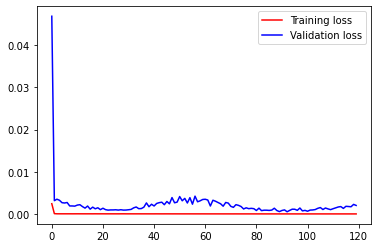

In [246]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend(loc=0)

In [247]:
# demonstrate prediction
yhat = model.predict(X)
yhat_valid = model.predict(X_valid)

In [248]:
def reverse(X,scale):
    return X*scale[0]+scale[1]
yhat = reverse(yhat,[scaler.data_range_[-1],scaler.data_min_[-1]])
yhat_valid = reverse(yhat_valid,[scaler.data_range_[-1],scaler.data_min_[-1]])
y = reverse(y,[scaler.data_range_[-1],scaler.data_min_[-1]])
y_valid = reverse(y_valid,[scaler.data_range_[-1],scaler.data_min_[-1]])

In [249]:
form(yhat,y,mode=0)


Mean
[109.72211, '%3.556552095017509', '||||', 86.36688, '%1.0393330854762404']
[115.70276, '-%0.7133088532495551', '||||', 92.679504, '-%3.046236448639422']

Count
[593, 228]
[77, 599]
acc %0.7962591850367402

Max
[1648.458, '%27.502328089469152', '||||', 798.06934, '%5.274952201785443']
[502.29297, '-%4.433482706180902', '||||', 1255.7637, '-%39.0133258545847']

Min
[0.04638672, '%0.00016216279397074373', '||||', 4.0324707, '%0.0038462730264976486']
[1.2710571, '-%0.0016389615947964842', '||||', 0.07421875, '-%0.008778549982868533']



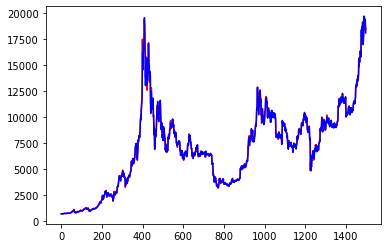

In [250]:
fig, ax = plt.subplots()
ax.plot(y,color="r")
ax.plot(yhat,color="b")

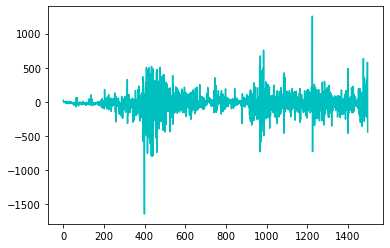

In [251]:
y=y.reshape((y.shape[0],1))
dif_y=yhat-y
fig, ax = plt.subplots()#figsize=(120, 60)
ax.plot(dif_y,color='c')

In [252]:
#X_valid, y_valid = split_sequences(dataset.values[1500:,:], n_steps)

In [253]:
form(yhat_valid,y_valid,mode=0)


Mean
[2154.3408, '%3.4490618929572636', '||||', 638.79755, '%1.1809591735144176']
[3329.1404, '-%2.124321197172706', '||||', 1467.3881, '-%6.139472366888142']

Count
[188, 6]
[135, 39]
acc %0.6168478260869565

Max
[7621.328, '%19.51077936477894', '||||', 1152.2715, '%2.867689489079628']
[7325.6875, '-%8.851289035613597', '||||', 6237.6875, '-%14.4982777378171']

Min
[24.925781, '%0.04668167553416591', '||||', 101.38281, '%0.14190794448523114']
[315.54297, '-%0.023389678593144225', '||||', 265.92188, '-%0.49562321805088905']



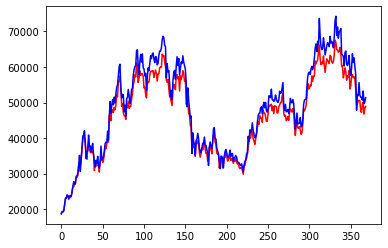

In [254]:
fig, ax = plt.subplots()
ax.plot(y_valid,color="r")
ax.plot(yhat_valid,color="b")

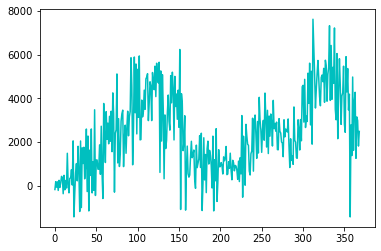

In [255]:
y_valid=y_valid.reshape((y_valid.shape[0],1))
dif_y_valid=yhat_valid-y_valid
fig, ax = plt.subplots()#figsize=(120, 60)
ax.plot(dif_y_valid,color='c')